# Simple Policy Optimization
Notebook for trying out the tooling involved in using policy gradient methods to train a model on SpaceInvaders.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
import numpy as np
tfd = tfp.distributions
%matplotlib inline

In [2]:
# Edge TPU for embedding extraction
from edgetpu.basic import basic_engine

In [3]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
# !pip install gym[box2d]

In [4]:
model_path = os.path.join(
    os.environ.get('HOME'), 'Work', 'ExternCode', 'edgetpu_models',
    'mobilenet_v1_1.0_224_quant_embedding_extractor_edgetpu.tflite')

In [5]:
tf.__version__

'2.1.0'

In [6]:
tf.executing_eagerly()

True

In [7]:
tfp.__version__

'0.9.0'

# Create Car Racing environment 

In [8]:
env_name = 'CarRacing-v0' # 'SpaceInvaders-v0'
env = gym.make(env_name)

In [9]:
env.observation_space

Box(96, 96, 3)

In [10]:
env.action_space

Box(3,)

Track generation: 1051..1317 -> 266-tiles track


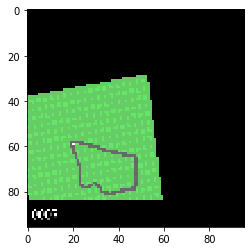

In [11]:
_ = plt.imshow(env.reset())

In [12]:
env.action_space.low, env.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [13]:
# Sampling from action space randomly
# tfd.Multinomial(total_count=1, logits=[-1.] * env.action_space.n).sample(1)
env.action_space.sample()

array([-0.6816686 ,  0.22567683,  0.19059433], dtype=float32)

# Next step: create h x w x n_frame tensor 
We can implement sequence of frames by allocating an initial h x w x n_frame tensor and for each new frame
rolling the tensor along axis 2 then assigning the new frame to channel 0. Is there a better or more idiomatic way to do this?
Could concatenate each new frame onto buffer.

In [14]:
n_row_col = 2
n_frame = n_row_col**2  # Square number for tiling
buffer = tf.zeros((n_frame,) + env.observation_space.shape, dtype=tf.uint8)

In [15]:
buffer.shape

TensorShape([4, 96, 96, 3])

In [16]:
# f = plt.figure()
for i in range(100):
    obs, reward, done, info = env.step(env.action_space.sample())
    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
#     _ = plt.imshow(buffer[0, ...])
#     plt.show()

In [17]:
def seq_to_img(seq, n):
    res = []
    for i in range(n):
        res.append(tf.concat([seq[i*n + j, ...] for j in range(n)], axis=1))
    return tf.concat(res, axis=0)

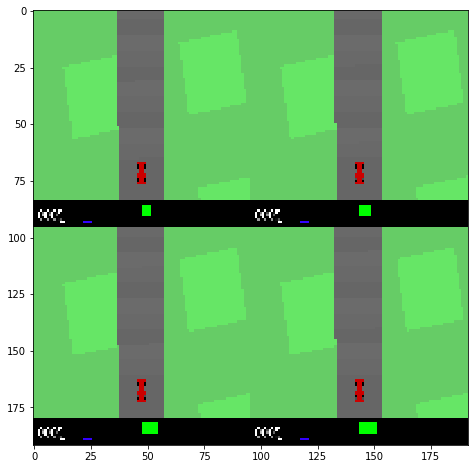

In [18]:
fig = plt.figure(figsize=(12,8))
# _ = plt.imshow(tf.reshape(tf.transpose(buffer, perm=[3, 2, 1, 0]), (2*96, 2*96, -1)))
_ = plt.imshow(seq_to_img(buffer, n_row_col))
ax = plt.gca()
# ax.axis('equal')
ax.set_aspect('equal', 'box')
# fig.savefig('test.png')

# Extract embedding
Use the MobileNet v1 model running on EdgeTPU to convert the set of n_frame frames represented as a single image into a 1024 element feature vector

In [19]:
engine = basic_engine.BasicEngine(model_path=model_path)

In [20]:
engine.get_all_output_tensors_sizes()

array([1024], dtype=int32)

In [21]:
_, img_ht, img_wd, _ = engine.get_input_tensor_shape()

In [22]:
buff_resized = tf.image.resize(seq_to_img(buffer, n_row_col), (img_ht, img_wd), method='nearest').numpy()

In [23]:
buff_resized.shape

(224, 224, 3)

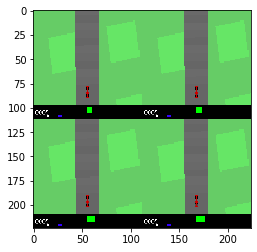

In [24]:
_ = plt.imshow(buff_resized)

In [25]:
_, _ = engine.run_inference(buff_resized.flatten()) # First run is slower, ignore
time_ms, embedding = engine.run_inference(buff_resized.flatten())
print(f'Time taken to extract embedding: {time_ms:.2f}ms')

Time taken to extract embedding: 3.54ms


In [26]:
embedding

array([3.24693   , 0.        , 0.        , ..., 0.23528478, 0.        ,
       0.        ], dtype=float32)

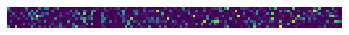

In [27]:
_ = plt.imshow(embedding.reshape(8, -1))
_ = plt.gca().axis('off')

In [28]:
embedding.shape

(1024,)

# Define the policy network
Now that we have a simple observation space to work with we can look at creating a policy network from it.
Our action space is 3D \[0., 1.\] unit cube (-1.,-1 for first dimension) which suggests we could sample each action dimension from a Beta distribution. The Beta distribution is defined by two non-negative parameters a and b so a simple policy network can be created by using a single fully connected layer with exponential activation function.

In [29]:
inputs = tf.keras.layers.Input(shape=(1024, ))
fc = tf.keras.layers.Dense(6, activation='exponential')(inputs)
unscaled_actions = tfp.layers.DistributionLambda(
    lambda x: tfd.Beta(x[...,:3], x[..., 3:])
)(fc)
network = tf.keras.Model(inputs, unscaled_actions)

In [30]:
network.build(input_shape=(1024, ))

In [31]:
network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6150      
_________________________________________________________________
distribution_lambda (Distrib ((None, 3), (None, 3))    0         
Total params: 6,150
Trainable params: 6,150
Non-trainable params: 0
_________________________________________________________________


In [32]:
network(embedding.reshape((1,-1))).sample(10)

<tf.Tensor: shape=(10, 1, 3), dtype=float32, numpy=
array([[[0.9989521 , 0.6582681 , 1.        ]],

       [[1.        , 0.30402428, 0.9993561 ]],

       [[0.9999994 , 0.8351853 , 0.98845756]],

       [[0.99999964, 0.50867325, 1.        ]],

       [[0.9939886 , 0.6901777 , 0.99999744]],

       [[0.99991876, 0.28959063, 0.99999934]],

       [[1.        , 0.34299964, 1.        ]],

       [[0.99966085, 0.08041651, 0.9981661 ]],

       [[1.        , 0.14283726, 1.        ]],

       [[0.9999767 , 0.07571539, 0.9997874 ]]], dtype=float32)>